In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import optuna
import xgboost as xgb

from pandarallel import pandarallel
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn.feature_selection import SelectKBest, f_regression


### Primary analysis

In [2]:
df = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(df.shape))
df.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Data set fields description

**Data related to a customer or taxi vendor:**
* id - unique trip id
* vendor_id - unique vendor id

**Time descriptors:**
* pickup_datetime - date/time when taxi counter was switched on
* dropoff_datetime - date/time when taxi counter was switched off

**Geo descriptors:**
* pickup_longitude -  trip start longitude
* pickup_latitude - trip start latitude
* dropoff_longitude - trip stop longitude
* dropoff_latitude - trip stop latitude

**Others:**
* passenger_count - passenger quantity in a car (driver input)
* store_and_fwd_flag - save and forward trip data to a vendor, flag.

**Target:**
* trip_duration - trip duration (sec)

In [3]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)
df['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

In [4]:
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [5]:
#display(df['vendor_id'].value_counts())
df[['vendor_id', 'passenger_count', 'trip_duration']].describe().round()

,vendor_id,passenger_count,trip_duration
count,1458644.0,1458644.0,1458644.0
mean,2.0,2.0,959.0
std,0.0,1.0,5237.0
min,1.0,0.0,1.0
25%,1.0,1.0,397.0
50%,2.0,1.0,662.0
75%,2.0,2.0,1075.0
max,2.0,9.0,3526282.0


### Feature generation

In [6]:
def add_datetime_features(data):
    """add some features related to date&time

    Args:
        data (dataframe): sorce data frame

    Returns:
        dataframe: modified dataframe
    """
    
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data

df = add_datetime_features(df)

display(f"trip per day-of-week statistic:", df.groupby(['pickup_day_of_week'])['trip_duration'].agg(quantity = 'count', median = 'median'))
print(f"average trips per day: {round(df.shape[0] / df['pickup_date'].nunique())}")


'trip per day-of-week statistic:'

,quantity,median
pickup_day_of_week,,
Friday,223533,686.0
Monday,187418,630.0
Saturday,220868,637.0
Sunday,195366,602.0
Thursday,218574,709.0
Tuesday,202749,679.0
Wednesday,210136,694.0


average trips per day: 8015


Let's add the information about the holidays in 2016: if ф pick up day was a holiday. 


In [7]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')


def add_holiday_features(df_main, df_holy):
    holidays = df_holy['date'].unique().tolist()
    df_main['pickup_holiday'] = df_main['pickup_date'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in holidays else 0)
    return df_main

df = add_holiday_features(df, holiday_data)

display(f"Median trip duration on holidays (1):", df.groupby(['pickup_holiday'])['trip_duration'].median())

'Median trip duration on holidays (1):'

pickup_holiday
0    665.0
1    585.0
Name: trip_duration, dtype: float64

In [8]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
print(f"BEFORE: shape - {df.shape} | nulls - {df.isna().T.any().sum()}")

def add_osrm_features(df_main, df_osrm):
    """add some features related to trip path based on osrm data

    Args:
        df_main (dataframe): source dataframe
        df_osrm (dataframe): osrm dataframe

    Returns:
        dataframe: merged data
    """
    df_osrm = df_osrm[['id','total_distance', 'total_travel_time', 'number_of_steps']]
    return df_main.merge(df_osrm, how='left', on='id', suffixes=(None,None))


df = add_osrm_features(df, osrm_data)

print(f" AFTER: shape - {df.shape} | nulls - {df.isna().T.any().sum()}")
print(f"trip_duration(median) - total_travel_time(median): {round(df['trip_duration'].median() - df['total_travel_time'].median())}")

BEFORE: shape - (1458644, 15) | nulls - 0
 AFTER: shape - (1458644, 18) | nulls - 1
trip_duration(median) - total_travel_time(median): 372


OSRM (Open Source Routing Machine) is an open, free resource that is actively used in many services that involve building the shortest route. It allows you to build an optimal piecewise linear path from point A to point B, as well as find out its approximate duration and length. Let's generate new features providing more useful details about trips 

Haversine formula determines the shortest distance between two points on a sphere if the latitude and longitude of each point are known. Geometrically, this is the length of the shortest arc connecting points on the sphere.

<img src='2.png'>

R - the Earth radius, h - distance between two points

In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # transform degrees to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    EARTH_RADIUS = 6371 
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    # the shortest distance according the Haversine's formula
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    # count a movement direction angle alpha
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [10]:
%%time
pandarallel.initialize(progress_bar=False)

def add_geographical_features(data):
    """add geo-related features: haversine distance & angle direction

    Args:
        data (dataframe): source dataframe

    Returns:
        dataframe: modified dataframe
    """
    coordinates = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
    data['haversine_distance'] = data[coordinates].parallel_apply(lambda x: get_haversine_distance(*x), axis=1)
    data['direction'] = data[coordinates].parallel_apply(lambda x: get_angle_direction(*x), axis=1)
    return data

df = add_geographical_features(df)

print(40*'-',f"\nMedian haversine distance: {round(df['haversine_distance'].median(),2)}\n", 40*'-')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


---------------------------------------- 
Median haversine distance: 2.09
 ----------------------------------------
CPU times: user 109 ms, sys: 252 ms, total: 361 ms
Wall time: 10.6 s


Сlustering by geographic coordinates. The idea is to group all trips based on the start and end coordinates of the trip using clustering methods, thereby adding information about the areas in which the start and end points of the trip are located.

In [11]:
# training subset for geo clusterization
coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                    df[['dropoff_latitude', 'dropoff_longitude']]))

# implement a clusterization algorithm
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(data, method):
    """add cluster label based on Kmeans

    Args:
        data (dataframe): sorce dataframe
        method (fit method): fit clusterization method 

    Returns:
        dataframe: modified dataframe with geo_cluster feature
    """
    pred_cluster = method.predict(data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values)
    data['geo_cluster'] = pred_cluster
    return data


df = add_cluster_features(df, kmeans)

df.groupby(['geo_cluster'])['trip_duration'].agg(trip_qty='count', median_duration='median').sort_values(by='trip_qty')


/home/ss/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,trip_qty,median_duration
geo_cluster,,
2,2,802.0
8,5,385.0
6,18,496.5
1,7233,939.0
3,27022,2532.0
7,41171,1576.0
5,43619,1756.0
4,359233,669.0
9,383874,550.0


Let's add some info about weather conditions on the day of trip 

In [12]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data = weather_data.loc[:,['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour

def add_weather_features(main_df, weather_df):
    main_df = main_df.merge(weather_df, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], suffixes=(None,None))
    main_df = main_df.drop(['time', 'date', 'hour'], axis=1)
    return main_df

df = add_weather_features(df, weather_data)

print(f"Trips when it snowed: {df[df['events']=='Snow'].shape[0]}")
print(f"nulls in 'temperature', 'visibility', 'wind speed', 'precip', %: {round(100* df[['temperature', 'visibility', 'wind speed', 'precip']].isna().T.any().sum() / df.shape[0],2)}")


Trips when it snowed: 13126
nulls in 'temperature', 'visibility', 'wind speed', 'precip', %: 0.82


In [13]:
def fill_null_weather_data(data):
    fill_values = {
        'temperature': data.groupby('pickup_date')['temperature'].transform('median'),
        'visibility': data.groupby('pickup_date')['visibility'].transform('median'),
        'wind speed': data.groupby('pickup_date')['wind speed'].transform('median'),
        'precip': data.groupby('pickup_date')['precip'].transform('median'),
        'events': 'None',
        'total_distance': data['total_distance'].median(),
        'total_travel_time': data['total_travel_time'].median(),
        'number_of_steps': data['number_of_steps'].median(),
    }
    data = data.fillna(fill_values)
    return data


print(f"nan BEFORE filling: {df.isna().T.any().sum()}")
df = fill_null_weather_data(df)
print(f"nan AFTER filling: {df.isna().T.any().sum()}")

print(f"Temperature(median): {df['temperature'].median()}")

nan BEFORE filling: 1387217
nan AFTER filling: 0
Temperature(median): 11.1


Having removed obvious outliers is supposed to improve model score and minimize model variance/bias.



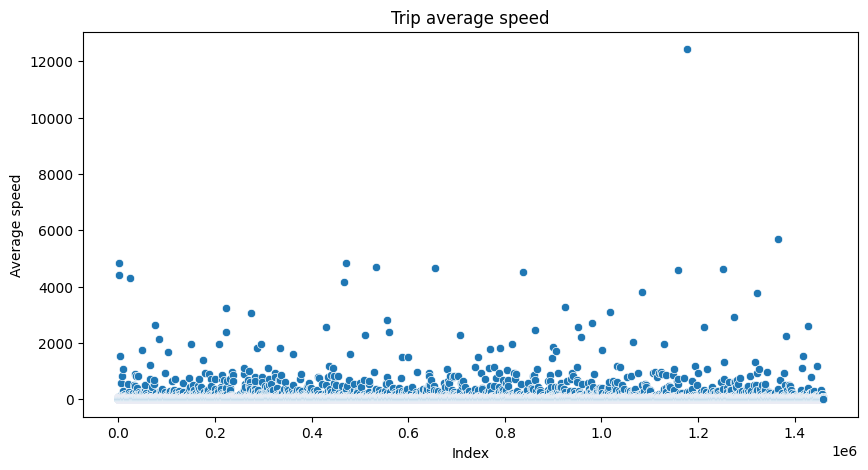

In [14]:
avg_speed = df['total_distance'] / df['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set(title='Trip average speed')
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

In [15]:
mask1 = df['trip_duration'] > 60*60*24
mask2 = df['total_distance'] / df['trip_duration'] * 3.6 > 300

print(f"Trip duration > 24hrs: {df[mask1].shape[0]} outliers")
print(f"Trip speed > 300km/hr: {df[mask2].shape[0]} outliers")

df = df[~((mask1) | (mask2))]

df.shape

Trip duration > 24hrs: 4 outliers
Trip speed > 300km/hr: 407 outliers


(1458233, 26)

In [16]:
df['trip_duration_log'] = np.log(df['trip_duration']+1)

### EDA

p-value for trip duration normality test: 0.00


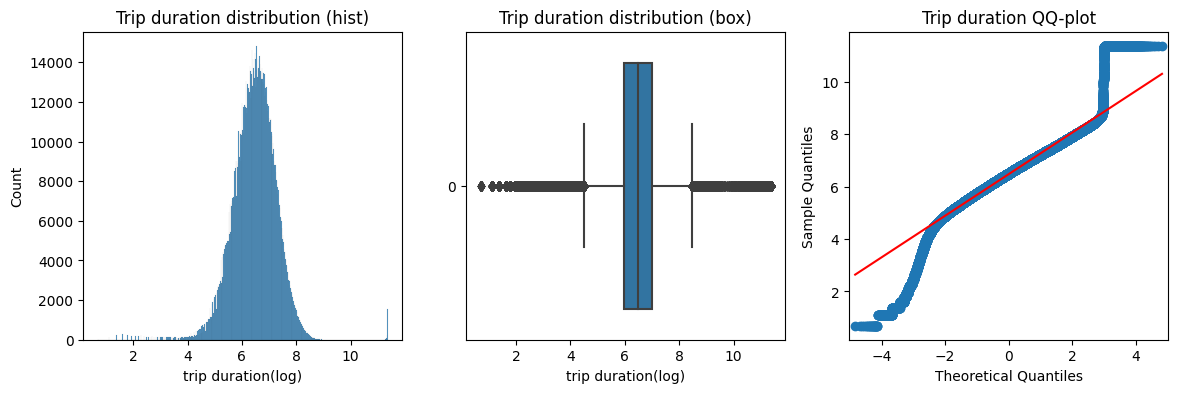

In [17]:
f,a = plt.subplots(1,3,figsize=(14,4))
sns.histplot(df['trip_duration_log'], ax=a[0]).set(title='Trip duration distribution (hist)', xlabel='trip duration(log)');
sns.boxplot(df['trip_duration_log'], ax=a[1], orient='h').set(title='Trip duration distribution (box)', xlabel='trip duration(log)');
sm.qqplot(df['trip_duration_log'], line='s', ax=a[2])
plt.title('Trip duration QQ-plot')

_,p = stats.normaltest(df['trip_duration_log'])
print("p-value for trip duration normality test: %.2f" % (p))

In [18]:
df.groupby(['vendor_id'])['id'].agg(qty='count')

,qty
vendor_id,
1,678115
2,780118


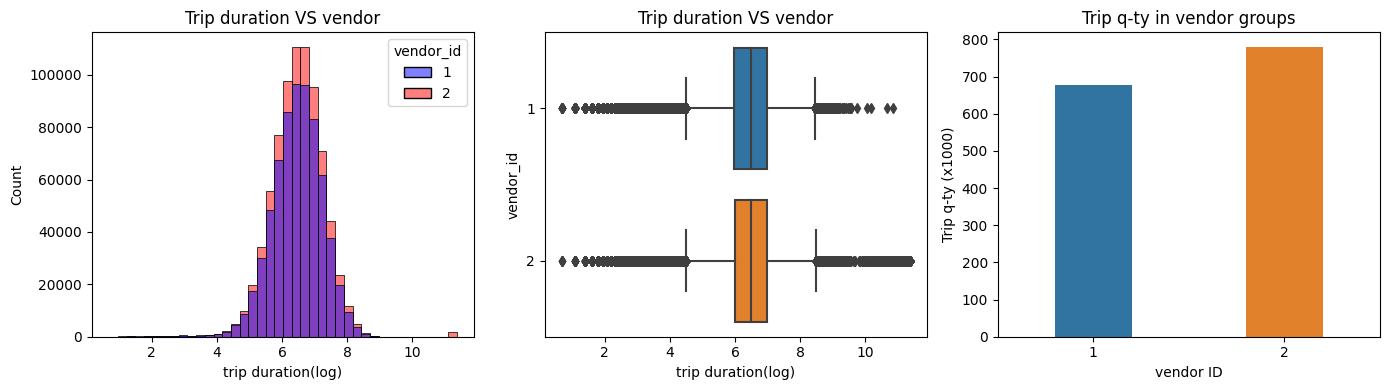

In [19]:
f,a = plt.subplots(1,3, figsize=(14,4))
sns.histplot(df, x='trip_duration_log', hue='vendor_id', ax=a[0], palette=['blue', 'red'], bins=40).set(title='Trip duration VS vendor', xlabel='trip duration(log)');
sns.boxplot(df, y='vendor_id', x='trip_duration_log', orient='h', ax=a[1]).set(title='Trip duration VS vendor', xlabel='trip duration(log)');

df_vendor = df.groupby(['vendor_id'])['id'].agg(qty='count')
sns.barplot(df_vendor, x= df_vendor.index, y=df_vendor['qty']/1e3, orient='v', ax=a[2], width=0.4).set(title='Trip q-ty in vendor groups', xlabel='vendor ID', ylabel='Trip q-ty (x1000)');
plt.tight_layout()


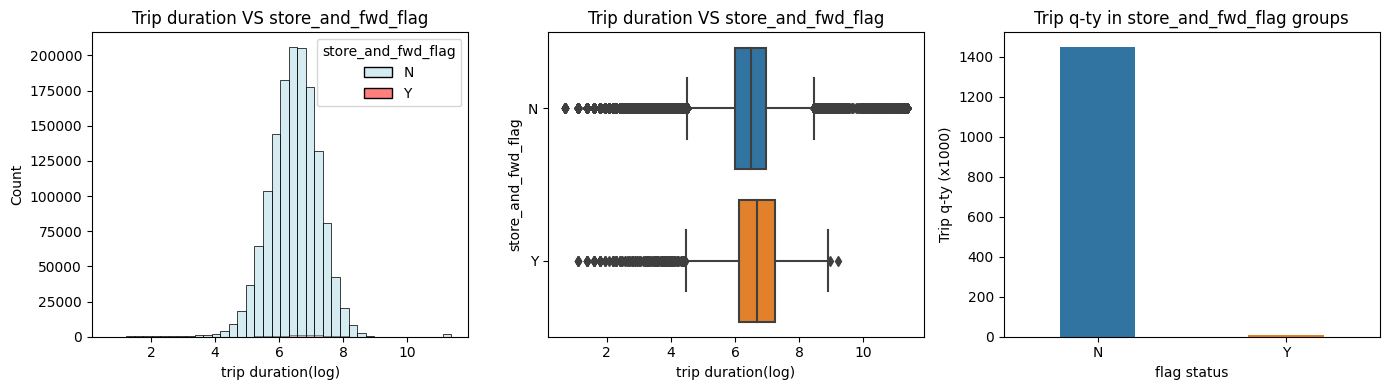

In [20]:
f,a = plt.subplots(1,3, figsize=(14,4))
sns.histplot(df, x='trip_duration_log', hue='store_and_fwd_flag', ax=a[0], palette=['lightblue', 'red'], bins=40).set(title='Trip duration VS store_and_fwd_flag', xlabel='trip duration(log)');
sns.boxplot(df, y='store_and_fwd_flag', x='trip_duration_log', orient='h', ax=a[1]).set(title='Trip duration VS store_and_fwd_flag', xlabel='trip duration(log)');

df_flag = df.groupby(['store_and_fwd_flag'])['id'].agg(qty='count')
sns.barplot(df_flag, x= df_flag.index, y=df_flag['qty']/1e3, orient='v', ax=a[2], width=0.4).set(title='Trip q-ty in store_and_fwd_flag groups', xlabel='flag status', ylabel='Trip q-ty (x1000)');
plt.tight_layout()

the longest trips belong to group N (do not store or forward the trip). Thus, the flag is saved only for short-term trips, but not for abnormal multi-hour trips.

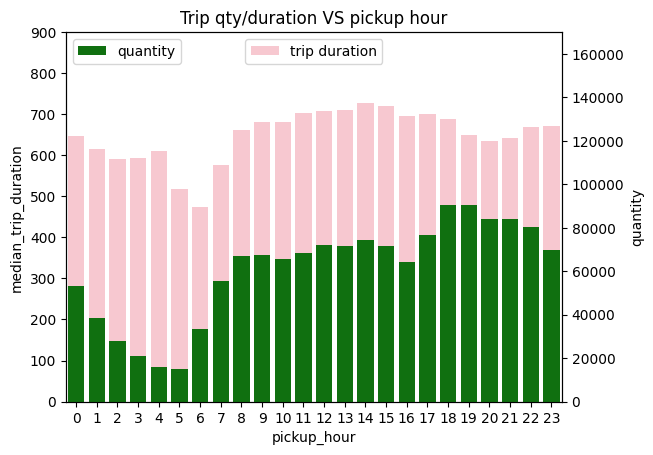

In [21]:
df_hour = df.groupby('pickup_hour')['trip_duration'].agg(quantity='count', median_trip_duration='median')
sns.barplot(df_hour, x=df_hour.index, y='median_trip_duration', color='pink', label='trip duration', orient='v').set(ylim=(None,900));
plt.legend(loc='upper center');
ax2=plt.twinx()
sns.barplot(df_hour, x=df_hour.index, y='quantity', orient='v', color='green', label='quantity', ax=ax2).set(title='Trip qty/duration VS pickup hour', ylim=(None,170e3));
plt.legend(loc='upper left');

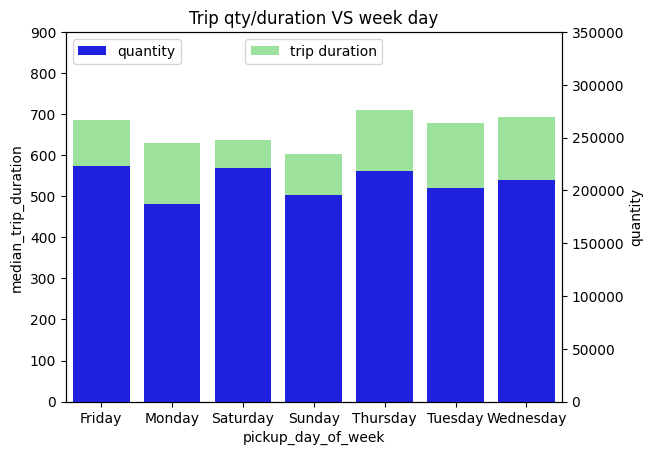

In [22]:
df_hour = df.groupby('pickup_day_of_week')['trip_duration'].agg(quantity='count', median_trip_duration='median')
sns.barplot(df_hour, x=df_hour.index, y='median_trip_duration', color='lightgreen', label='trip duration', orient='v').set(ylim=(None,900));
plt.legend(loc='upper center');
ax2=plt.twinx()
sns.barplot(df_hour, x=df_hour.index, y='quantity', orient='v', color='blue', label='quantity', ax=ax2).set(title='Trip qty/duration VS week day', ylim=(None,350e3));
plt.legend(loc='upper left');

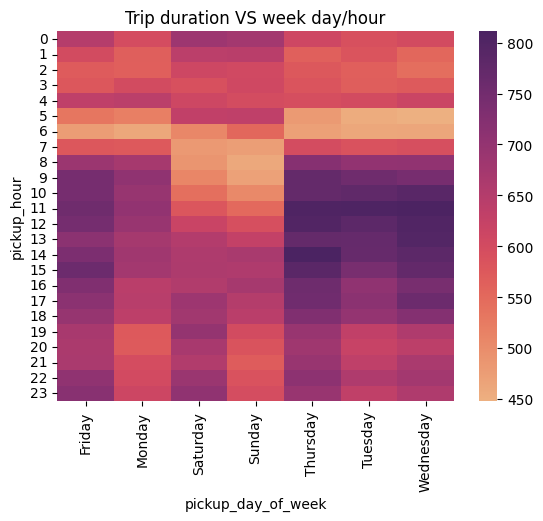

In [23]:
pivot = df.pivot_table(
    index='pickup_hour',
    columns='pickup_day_of_week',
    values='trip_duration',
    aggfunc='median'
)
sns.heatmap(pivot, cmap='flare').set(title='Trip duration VS week day/hour');

/home/ss/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ss/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


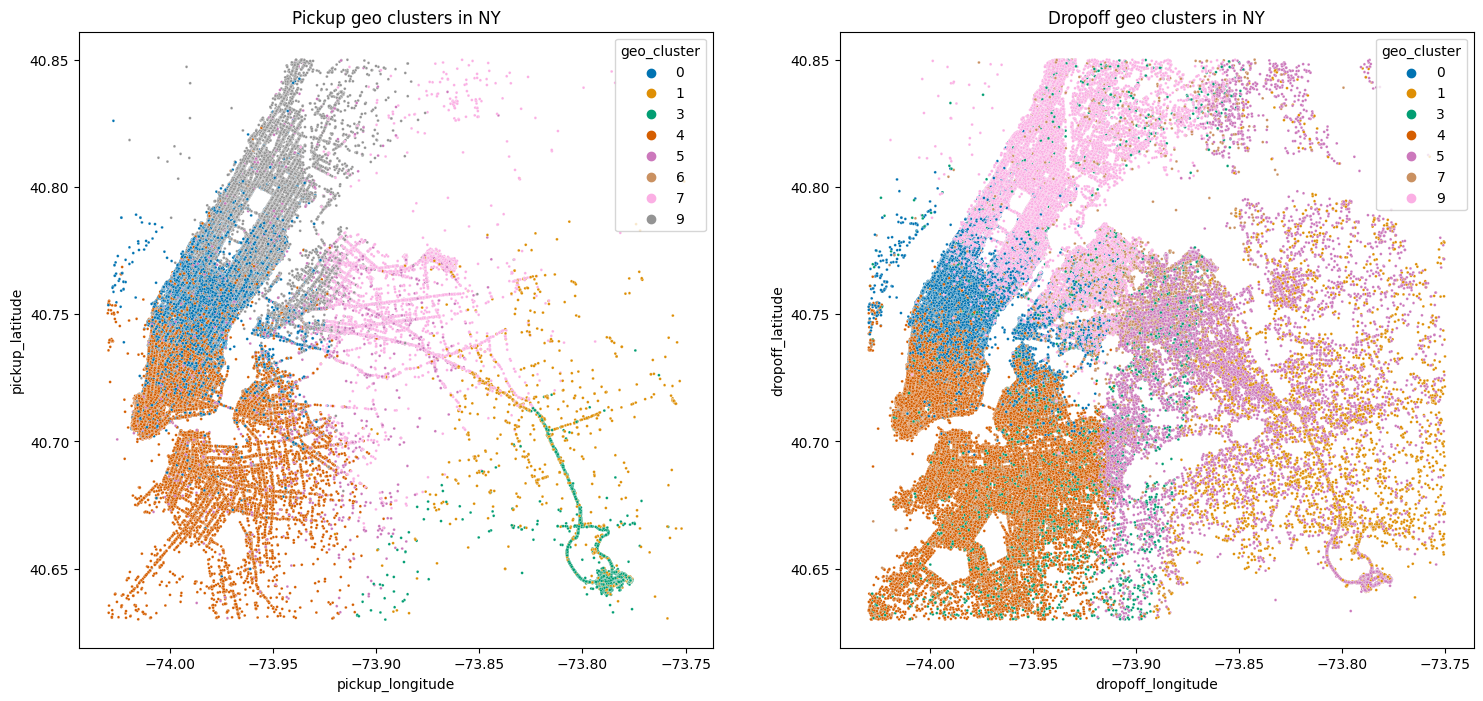

In [24]:
f,a = plt.subplots(1,2,figsize=(18,8))
pickup_lim = (df['pickup_longitude']>-74.03) & (df['pickup_longitude']<-73.75) & (df['pickup_latitude']>40.63) & (df['pickup_latitude']<40.85)
dropoff_lim = (df['dropoff_longitude']>-74.03) & (df['dropoff_longitude']<-73.75) & (df['dropoff_latitude']>40.63) & (df['dropoff_latitude']<40.85)

sns.scatterplot(df[pickup_lim], 
                x='pickup_longitude', 
                y='pickup_latitude', 
                hue='geo_cluster', 
                s=4, 
                ax=a[0],
                palette='colorblind'
                #label='geo_cluster'
                ).set(title='Pickup geo clusters in NY');
#plt.legend(loc='upper right', markerscale=2);

sns.scatterplot(df[dropoff_lim], 
                x='dropoff_longitude', 
                y='dropoff_latitude', 
                hue='geo_cluster', 
                s=4, 
                ax=a[1], 
                palette='colorblind'
                #label='geo_cluster'
                ).set(title='Dropoff geo clusters in NY');
#plt.legend(loc='upper right', markerscale=2);

In [25]:
df['geo_cluster'].value_counts()
df[pickup_lim]['geo_cluster'].value_counts()

geo_cluster
0    596316
9    382989
4    358401
5     43579
7     40994
3     26990
1      6932
6         4
Name: count, dtype: int64

In [26]:
print('Shape of data: {}'.format(df.shape))
print('Columns: {}'.format(df.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


### Feature transformation

In [27]:
train_data = df.copy()

In [28]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
train_data.shape

(1458233, 25)

In [29]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


In [30]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

print(f"Vendor_id mean value: {train_data['vendor_id'].mean().round(2)}")
print(f"Store_and_fwd_flag mean value: {train_data['store_and_fwd_flag'].mean().round(3)}")

Vendor_id mean value: 0.53
Store_and_fwd_flag mean value: 0.006


In [31]:
ohe_cols = ['pickup_day_of_week', 'geo_cluster', 'events']

ohe = preprocessing.OneHotEncoder(drop='first')
data_onehot = ohe.fit_transform(train_data[ohe_cols]).toarray()

col_names = ohe.get_feature_names_out(ohe_cols)
data_onehot = pd.DataFrame(data_onehot, columns=col_names)
display(data_onehot.shape)

train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(ohe_cols, axis=1), #use the drop parameter to avoid the old index being added as a column
     data_onehot],  
    axis=1)

print('Shape of data: {}'.format(train_data.shape))

(1458233, 18)

Shape of data: (1458233, 38)


In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

In [33]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

### Selecting best features

In [34]:
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_fea = selector.get_feature_names_out()
X_train = X_train[best_fea]
X_valid = X_valid[best_fea]
best_fea

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_Monday',
       'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday',
       'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday',
       'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [35]:
cols = X_train.columns
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=cols)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=cols)

print(f"Mean value for 0-column in X_valid: {X_valid_scaled.iloc[:,0].mean().round(2)}")

Mean value for 0-column in X_valid: 0.54


### Metric

RMSLE (Root Mean Squared Log Error) - our metric for model evaluation:

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$


$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### LinearRegression

In [36]:
lr = linear_model.LinearRegression()

lr.fit(X_train_scaled, y_train_log)

y_train_pred = lr.predict(X_train_scaled)
y_valid_pred = lr.predict(X_valid_scaled)

print(f"Linear Regression error (rmsle) on train subset: {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2)}")
print(f"Linear Regression error (rmsle) on valid. subset: {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2)}")

Linear Regression error (rmsle) on train subset: 0.54
Linear Regression error (rmsle) on valid. subset: 0.54


In [37]:
#poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#poly.fit(X_train_scaled)

#X_train_scaled_poly = poly.transform(X_train_scaled)
#X_valid_scaled_poly = poly.transform(X_valid_scaled)

#lr.fit(X_train_scaled_poly, y_train_log)

#y_train_pred = lr.predict(X_train_scaled_poly)
#y_valid_pred = lr.predict(X_valid_scaled_poly)

#print(f"{np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2)}")
#print(f"{np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2)}")

In [38]:
ridge = linear_model.Ridge(alpha=1, solver='svd')

#ridge.fit(X_train_scaled_poly, y_train_log)

#y_train_pred = ridge.predict(X_train_scaled_poly)
#y_valid_pred = ridge.predict(X_valid_scaled_poly)

#print(f"{np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2)}")
#print(f"{np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2)}")

### DecisionTreeRegressor

In [39]:
dtr = tree.DecisionTreeRegressor(random_state=42)

dtr.fit(X_train_scaled, y_train_log)

y_train_pred = dtr.predict(X_train_scaled)
y_valid_pred = dtr.predict(X_valid_scaled)

print(f"DecisionTree error (rmsle) w default parameters on train subset: {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2)}")
print(f"DecisionTree error (rmsle) w default parameters on valid. subset: {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2)}")


DecisionTree error (rmsle) w default parameters on train subset: 0.0
DecisionTree error (rmsle) w default parameters on valid. subset: 0.57


This model is overfitted taking into account the difference in metric values for train and valid. sets. Let's handle it by optimizing max_depth

DecisionTree error with max_depth=12 (train subset): 0.41
DecisionTree error with max_depth=12 (valid. subset): 0.43


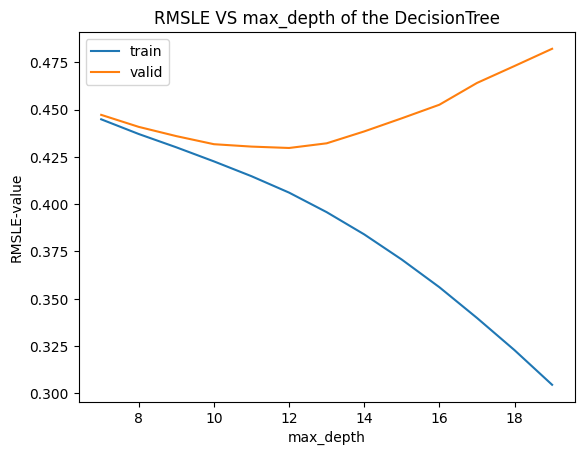

In [40]:
max_depths = range(7,20)

train_err = []
valid_err = []
for d in max_depths:
    dtr = tree.DecisionTreeRegressor(max_depth=d, random_state=42)
    dtr.fit(X_train_scaled, y_train_log)
    y_train_pred = dtr.predict(X_train_scaled)
    y_valid_pred = dtr.predict(X_valid_scaled)
    train_err.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)))
    valid_err.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)))


sns.lineplot(x=range(7,20), y=train_err, label='train').set(title='RMSLE VS max_depth of the DecisionTree', xlabel='max_depth', ylabel='RMSLE-value');
sns.lineplot(x=range(7,20), y=valid_err, label='valid');

print(f"DecisionTree error with max_depth=12 (train subset): {train_err[5].round(2)}")
print(f"DecisionTree error with max_depth=12 (valid. subset): {valid_err[5].round(2)}")

Max_depth = 12 seems to be optimal as it provides the minimal error with validation subset and the model isn't overfitted yet.

### RandomForestRegressor

In [41]:
rfr = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42
)

#rfr.fit(X_train_scaled, y_train_log)

#y_train_pred = rfr.predict(X_train_scaled)
#y_valid_pred = rfr.predict(X_valid_scaled)

#print(f"RandomForrestRegressor error (rmsle) w default parameters on train subset: {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2)}")
#print(f"RandomForrestRegressor error (rmsle) w default parameters on valid. subset: {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2)}")

#-->
#RandomForrestRegressor error (rmsle) on train subset: 0.4
#RandomForrestRegressor error (rmsle) on valid. subset: 0.41

### GradientBoostingRegressor

In [49]:
def optuna_rf(trial):
  n_estimators=trial.suggest_int('n_estimators', 50, 200, 10)
  max_depth=trial.suggest_int('max_depth', 2, 15, 1)
  min_samples_split=trial.suggest_int('min_samples_split', 10, 50, 5)
  learning_rate=trial.suggest_float('learning_rate', 0.1, 1.0)
  
  
  model = ensemble.GradientBoostingRegressor(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42)
  
  model.fit(X_train_scaled, y_train_log)
  #score_train = np.sqrt(metrics.mean_squared_error(y_train_log, model.predict(X_train_scaled)))
  score_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, model.predict(X_valid_scaled)))
  #score = cross_val_score(model, X, y, cv=10, scoring="f1", n_jobs=-1).mean()
  return score_valid


#study = optuna.create_study(study_name="GradBoostRegr", direction="minimize")
#study.optimize(optuna_rf, n_trials=10)



In [ ]:
gbr = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)

gbr.fit(X_train_scaled, y_train_log)

y_train_pred = gbr.predict(X_train_scaled)
y_valid_pred = gbr.predict(X_valid_scaled)

print(f"GradientBoostingRegressor error (rmsle) on train subset: {np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2)}")
print(f"GradientBoostingRegressor error (rmsle) on valid. subset: {np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2)}")

#-->
#GradientBoostingRegressor error (rmsle) on train subset: 0.37
#GradientBoostingRegressor error (rmsle) on valid. subset: 0.39

GradientBoostingRegressor error (rmsle) on train subset: 0.37
GradientBoostingRegressor error (rmsle) on valid. subset: 0.39


### The most important features used by GBR

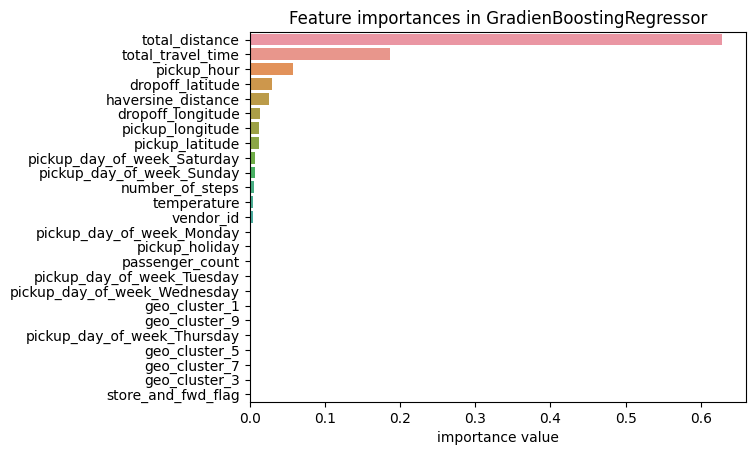

In [ ]:
fea_importance = pd.Series(gbr.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
sns.barplot(y=fea_importance.index, x = fea_importance, orient='h').set(title='Feature importances in GradienBoostingRegressor', xlabel='importance value');

In [ ]:
MeAE = metrics.median_absolute_error(np.exp(y_valid_log)-1, np.exp(y_valid_pred)-1).round(2)

print(f"GradientBoostingRegressor error (MeAE) on valid. subset: {round(MeAE/60,1)}")

GradientBoostingRegressor error (MeAE) on valid. subset: 1.8


### Treating test set

In [52]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

In [53]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = ohe.fit_transform(test_data[ohe_cols]).toarray()
column_names = ohe.get_feature_names_out(ohe_cols)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(ohe_cols, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_fea]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


### XGBoost

In [54]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_fea.tolist())
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_fea.tolist())
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_fea.tolist())

In [55]:
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(
    params=xgb_pars, 
    dtrain=dtrain, 
    num_boost_round=1000, 
    evals=watchlist, 
    early_stopping_rounds=20, 
    maximize=False, 
    verbose_eval=10 
)

[0]	train-rmse:0.73991	valid-rmse:0.74191
[10]	train-rmse:0.49088	valid-rmse:0.49347
[20]	train-rmse:0.44043	valid-rmse:0.44331
[30]	train-rmse:0.42620	valid-rmse:0.42929
[40]	train-rmse:0.41840	valid-rmse:0.42173
[50]	train-rmse:0.41324	valid-rmse:0.41684
[60]	train-rmse:0.40932	valid-rmse:0.41332
[70]	train-rmse:0.40627	valid-rmse:0.41059
[80]	train-rmse:0.40375	valid-rmse:0.40836
[90]	train-rmse:0.40168	valid-rmse:0.40662
[100]	train-rmse:0.39981	valid-rmse:0.40504
[110]	train-rmse:0.39851	valid-rmse:0.40401
[120]	train-rmse:0.39711	valid-rmse:0.40284
[130]	train-rmse:0.39572	valid-rmse:0.40183
[140]	train-rmse:0.39438	valid-rmse:0.40068
[150]	train-rmse:0.39329	valid-rmse:0.39993
[160]	train-rmse:0.39237	valid-rmse:0.39930
[170]	train-rmse:0.39156	valid-rmse:0.39885
[180]	train-rmse:0.39060	valid-rmse:0.39821
[190]	train-rmse:0.38997	valid-rmse:0.39789
[200]	train-rmse:0.38916	valid-rmse:0.39744
[210]	train-rmse:0.38853	valid-rmse:0.39699
[220]	train-rmse:0.38774	valid-rmse:0.39649

In [56]:
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.38809


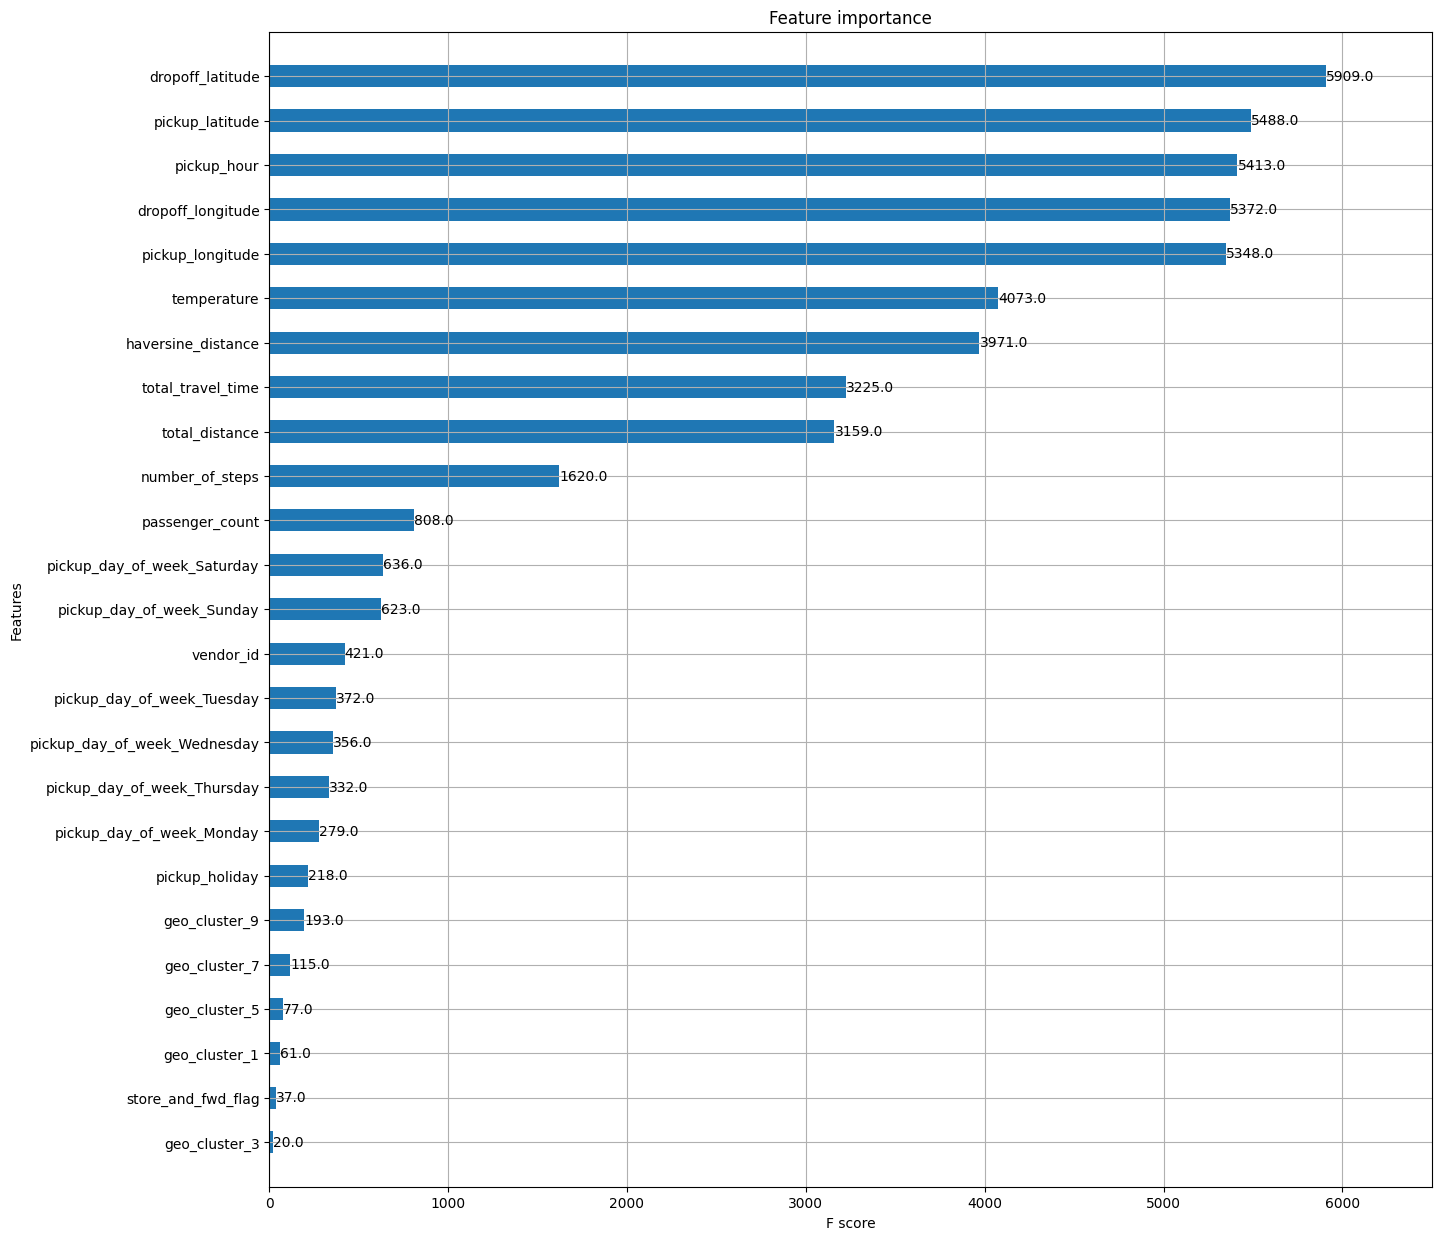

In [57]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5);

### Prepare submission

In [ ]:
y_test_pred = gbr.predict(X_test_scaled)

submission = pd.DataFrame({'id': test_id, 'trip_duration': np.exp(y_test_pred)-1})
submission.to_csv('data/submission_gb.csv', index=False)